In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, RocCurveDisplay, confusion_matrix, classification_report, plot_roc_curve, roc_auc_score, make_scorer, fbeta_score,accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_validate, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SequentialFeatureSelector
from time import time
from sklearn.linear_model import RidgeCV
import scikitplot as skplt
import plotly.express as px
import folium
import os
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier , plot_tree
# import eli5 
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import TransformerMixin
from sklearn.decomposition import TruncatedSVD
import warnings

random_state=42

In [2]:
data_df = pd.read_csv("hotel_bookings.csv")
pd.set_option("display.float_format", lambda x: "%.5f" % x)
pd.options.display.max_rows = 200000
data_df = data_df.drop(columns=["reservation_status_date", "hotel", "reservation_status",
    "arrival_date_week_number", "reserved_room_type", "company"])

data_df["total_guests"] = data_df["adults"] + data_df["children"] + data_df["babies"]
data_df["price_per_guest"] = data_df["adr"]/data_df["total_guests"]

filter = (data_df.children == 0) & (data_df.adults == 0) & (data_df.babies == 0)
data_df[filter]
data_df = data_df[~filter]
data_df=data_df.replace(" ","_")
data_df = data_df.reindex(data_df.columns.tolist(), axis = 1)

In [3]:
nan_replacements = {"children": 0.0, "agent": 0, "country": "unknown", "total_guests":0, "price_per_guest":0}
data_df = data_df.fillna(nan_replacements)
# data_df.info()

In [4]:
# data_df.describe()

In [5]:
data_df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
data_df.dropna(inplace=True)

data_df.drop(14969)
data_df.shape

(119210, 28)

In [6]:
# funkcja zwracająca cechy numeryczne
def get_quant_features(dataframe):
    feats = dataframe.select_dtypes([np.number, np.bool]).columns
    return [x for x in feats]

# funkcja rysująca histogramy dla numerycznych cechy
def draw_histograms(dataframe, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(16,10))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        dataframe[var_name].hist(bins=20,ax=ax)
        ax.set_title(var_name)
    fig.tight_layout()
    plt.show()

C:\Users\iwona\AppData\Local\Temp/ipykernel_32080/3624076162.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  feats = dataframe.select_dtypes([np.number, np.bool]).columns


20


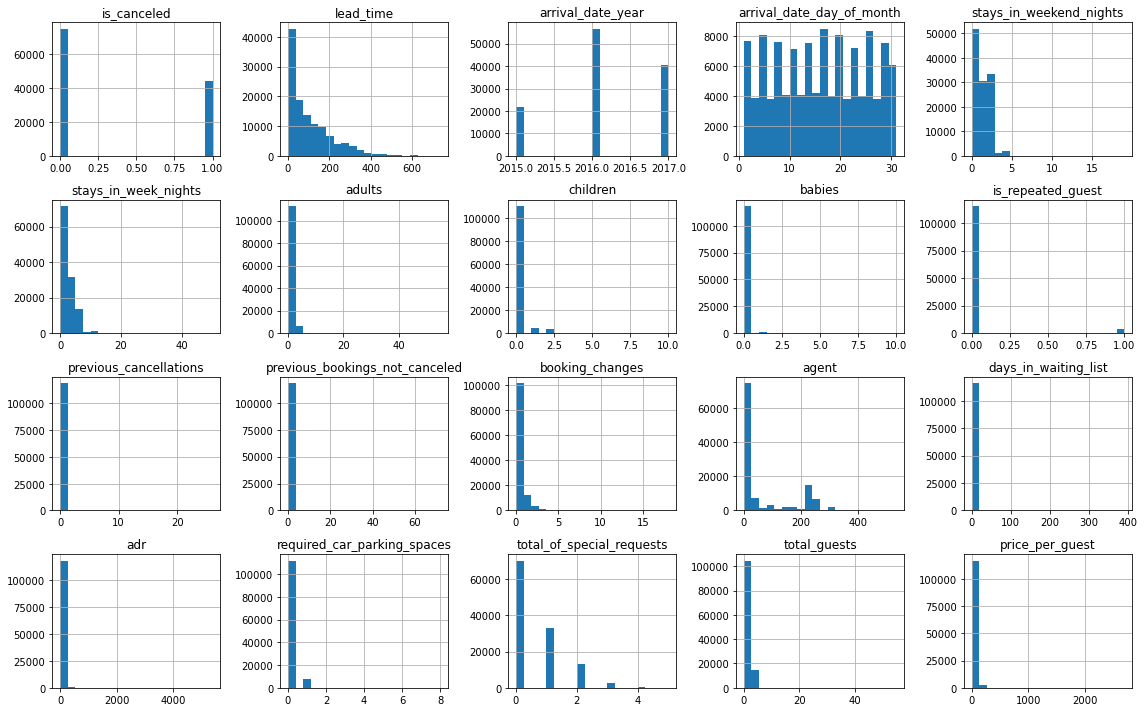

In [7]:
feats = get_quant_features(data_df)
print(len(feats))
draw_histograms(data_df, feats, 4, 5)

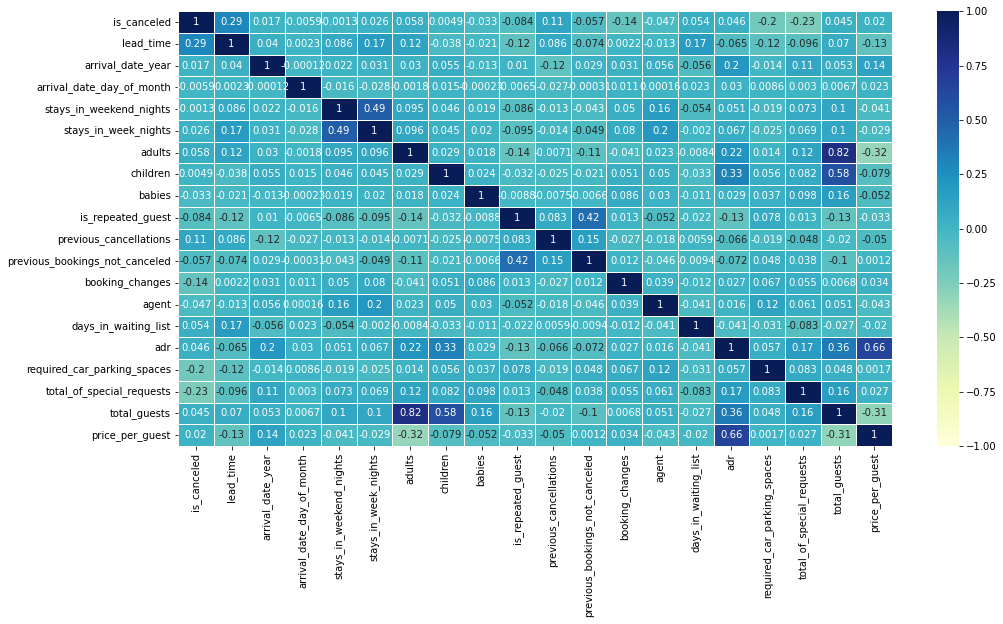

In [8]:
plt.rcParams["figure.figsize"]=(16,8)
sns.heatmap(data_df.corr(method="pearson",), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

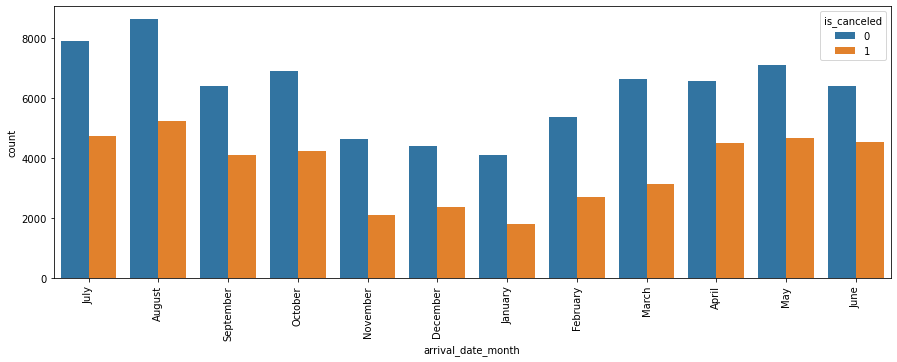

In [9]:
plt.figure(figsize=(15, 5))
sns.countplot(x="arrival_date_month", hue="is_canceled", data=data_df)
plt.xticks(rotation=90);

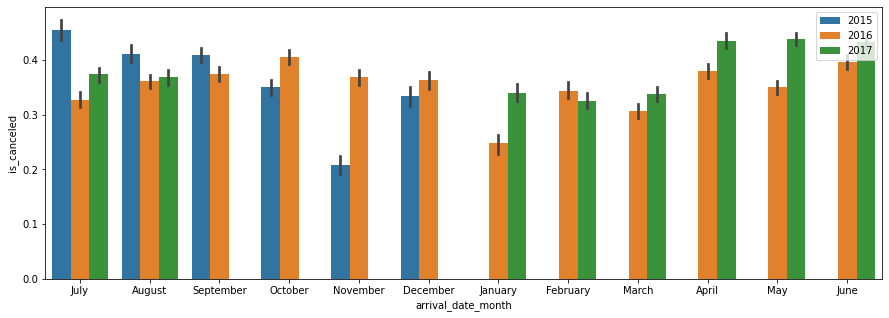

In [10]:
plt.figure(figsize=(15,5))
sns.barplot(x="arrival_date_month", y="is_canceled", hue="arrival_date_year", data=data_df)
plt.legend(loc="upper right");

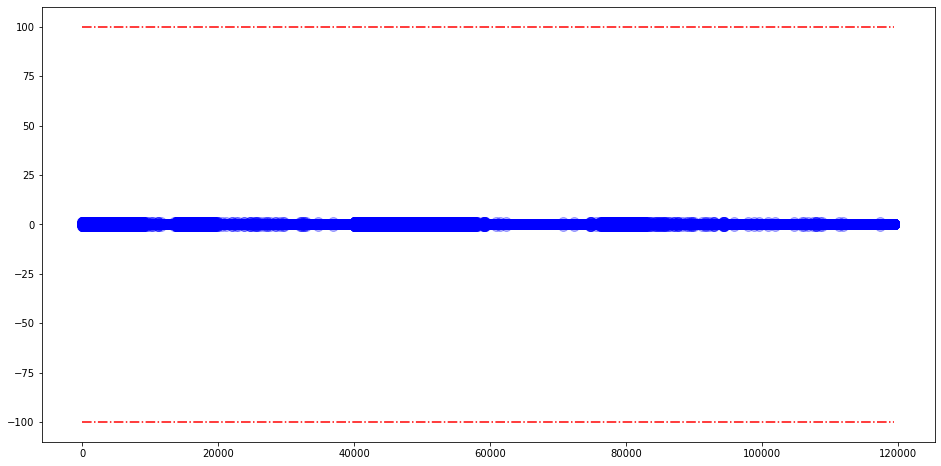

In [11]:
# sprawdzamy, czy są jakieś wartości odstające
# pd.diff() sprawdza różnice co do poprzedniego elementu
plt.plot(data_df.index, data_df["is_canceled"].diff(), "bo", alpha=0.3, ms=10, lw="3")

plt.hlines(xmin=data_df.index.min(), xmax=data_df.index.max(), y=100, color="r", linestyle="-.")
plt.hlines(xmin=data_df.index.min(), xmax=data_df.index.max(), y=-100, color="r", linestyle="-.");

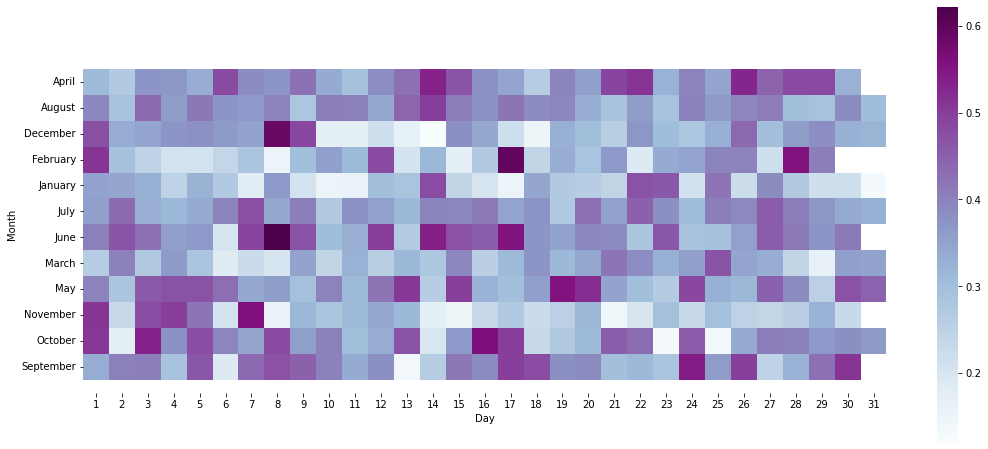

In [12]:
plt.figure(figsize=(18, 8))

# heatmap dla średniej PM2.5 dla godzin i miesięcy
df_train = data_df.groupby(["arrival_date_month", "arrival_date_day_of_month"])["is_canceled"].mean().reset_index()
df_train = df_train.pivot("arrival_date_month", "arrival_date_day_of_month", "is_canceled")
ax = sns.heatmap(df_train, cmap="BuPu", square=True)

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.xlabel("Day")
plt.ylabel("Month");

In [6]:
features = data_df.drop(columns=["is_canceled","total_guests"], axis=1).columns
# features

In [7]:
x = data_df[features]
y = data_df["is_canceled"]

In [8]:
# x = pd.get_dummies(x, drop_first=True)
# x.head()

my_label_encoder = LabelEncoder()

for el in x:
    if x[el].dtype == object:
        my_label_encoder.fit(x[el]) 
        tmp = my_label_encoder.transform(x[el]).reshape((-1,1))
        x[el] = pd.DataFrame(tmp)

x=x.fillna(0)

C:\Users\iwona\AppData\Local\Temp/ipykernel_35584/816599194.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[el] = pd.DataFrame(tmp)


In [9]:
models = [("Dummy_Model",DummyClassifier(strategy="stratified")),
            ("DecisionTree_Model", DecisionTreeClassifier(random_state=42)),
            ("RandomForest_Model", RandomForestClassifier(random_state=42)),
            ("LogisticRegression_Model", LogisticRegression(random_state=42, solver="liblinear")),
            ("XGBBoost_Model", XGBClassifier(random_state=42,use_label_encoder=False, eval_metric="mlogloss", n_jobs=-1)),
            ("Gaussian_Model", GaussianNB()),
            ("KNN_Model", KNeighborsClassifier())]

split = KFold(n_splits=4, shuffle=True, random_state=42)
fbeta_scorer = make_scorer(fbeta_score, beta=0.5)

In [10]:
# Preprocessing, fitting, making predictions and scoring for every model:
accuracy = []
fbeta = []
tm = []
model_name = []
for name, model in models:
    start = time()
    cv_results = cross_val_score(model, x, y, cv=split, scoring="accuracy")
    fbeta_res = cross_val_score(model, x, y, cv=split, scoring=fbeta_scorer)
    mean_score = round(np.mean(cv_results), 4)
    fbeta_score = round(np.mean(fbeta_res), 4)
    end = time()
    cross_val_time = round(end-start,4)
    accuracy.append(mean_score)
    fbeta.append(fbeta_score)
    tm.append(cross_val_time)
    model_name.append(name)
    print(f"{name}  f-beta: {fbeta_score}, accuracy score: {mean_score}, time: {cross_val_time}")

Dummy_Model  f-beta: 0.3706, accuracy score: 0.5338, time: 0.1807
DecisionTree_Model  f-beta: 0.7666, accuracy score: 0.8285, time: 5.0024
RandomForest_Model  f-beta: 0.8647, accuracy score: 0.8798, time: 87.2035
LogisticRegression_Model  f-beta: 0.7262, accuracy score: 0.781, time: 12.7137
XGBBoost_Model  f-beta: 0.8441, accuracy score: 0.87, time: 17.666
Gaussian_Model  f-beta: 0.4929, accuracy score: 0.5354, time: 0.6192
KNN_Model  f-beta: 0.6823, accuracy score: 0.7618, time: 19.0237


In [28]:
comparison = {"Models name": model_name,
                "Accuracy score":accuracy,
                "F-beta score": fbeta,
                "Time": tm}

In [29]:
pd.DataFrame(comparison)

,Models name,Accuracy score,F-beta score,Time
0,Dummy_Model,0.53430,0.36990,0.86270
1,DecisionTree_Model,0.85830,0.80790,13.23290
2,RandomForest_Model,0.89170,0.87300,138.51070
3,LogisticRegression_Model,0.81340,0.77270,11.19230
4,XGBBoost_Model,0.87660,0.84360,72.29350
5,Gaussian_Model,0.52560,0.48620,4.31330
6,KNN_Model,0.77390,0.69960,83.47850


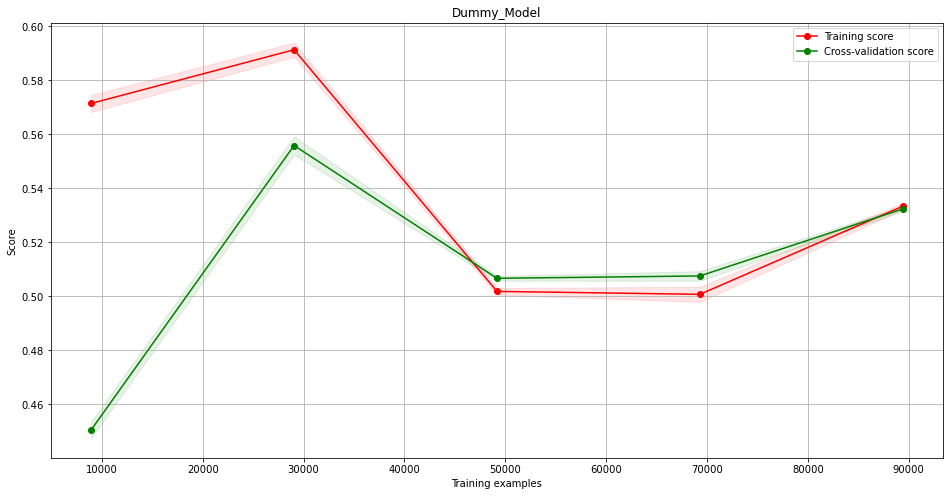

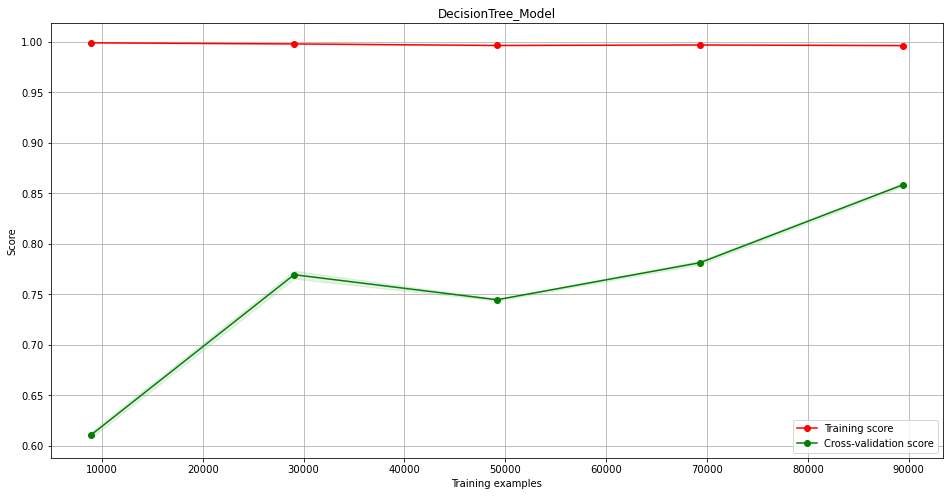

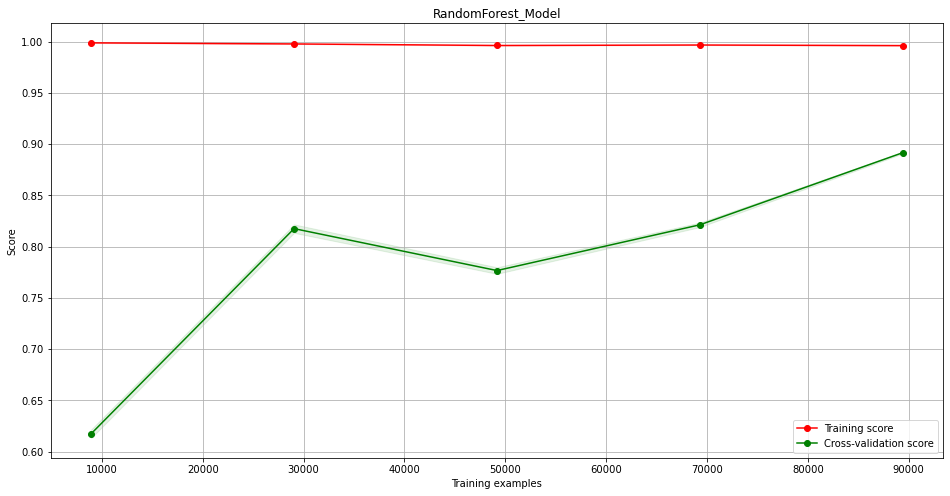

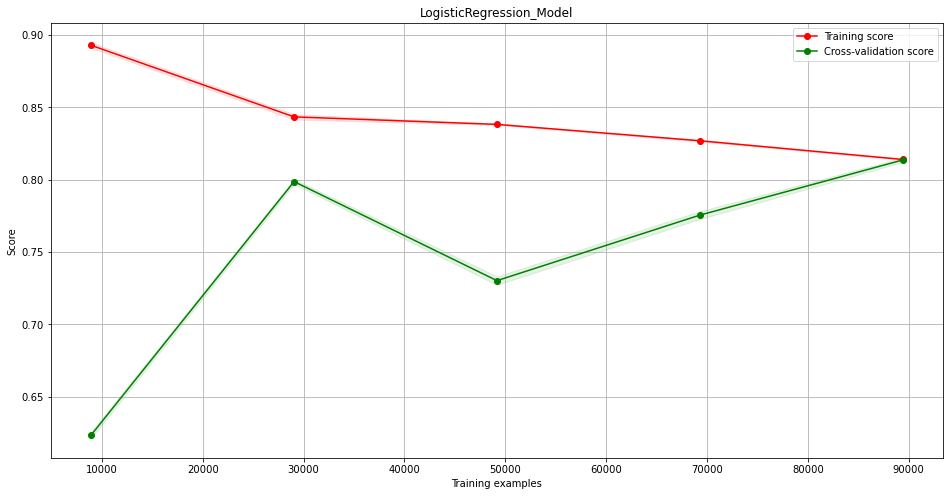

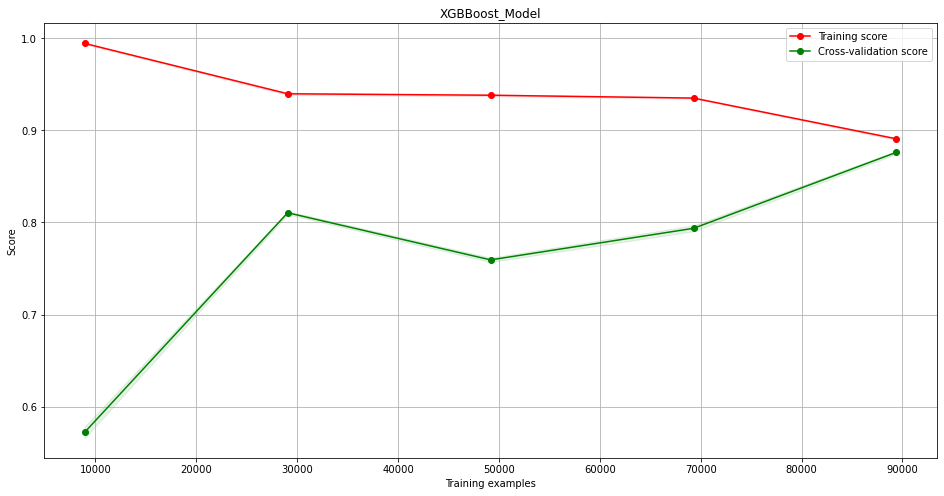

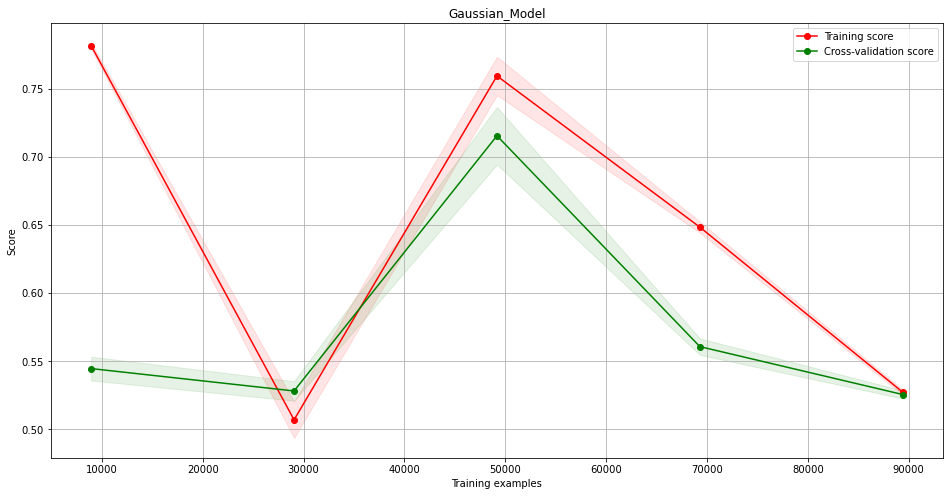

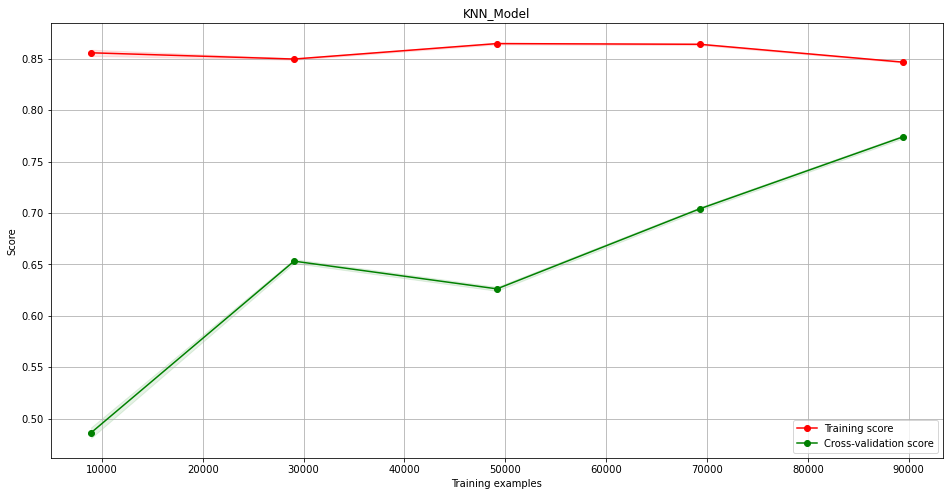

In [20]:
for name, model in models:
    skplt.estimators.plot_learning_curve(model, x, y,name, cv=split)
    plt.show()

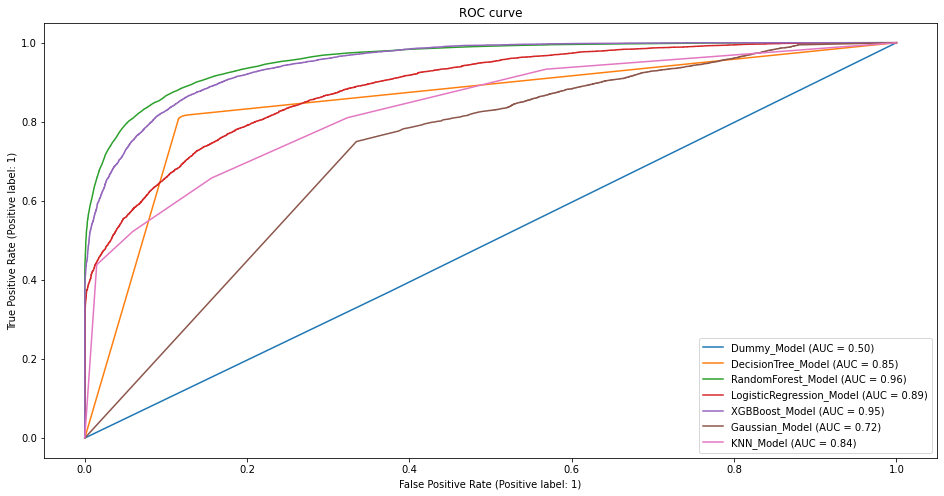

In [21]:
warnings.filterwarnings("ignore")


x1 = np.array(x)
y1= np.array(y)

fig, ax = plt.subplots()

for name, model in models:
    for i, (train, test) in enumerate(split.split(x1)):
        if i == 3:
            x1_train, x1_test = x1[train], x1[test]
            y1_train, y1_test = y1[train], y1[test]
            fit = model.fit(x1[train], y1[train])
            plot_roc_curve(model, x1_test, y1_test, ax=ax, name=name)
_ = ax.set_title("ROC curve")

In [22]:
x1 = np.array(x)
y1= np.array(y)

for name, model in models:
    for i, (train, test) in enumerate(split.split(x1)):
        if i == 3:
            x1_train, x1_test = x1[train], x1[test]
            y1_train, y1_test = y1[train], y1[test]
            fit = model.fit(x1[train], y1[train])
            y1_pred = model.predict(x1_test)
            print(f"{name}\n",confusion_matrix(y1_test, y1_pred))

Dummy_Model
 [[11855  7013]
 [ 6817  4117]]
DecisionTree_Model
 [[16647  2221]
 [ 2061  8873]]
RandomForest_Model
 [[17760  1108]
 [ 2100  8834]]
LogisticRegression_Model
 [[17164  1704]
 [ 3914  7020]]
XGBBoost_Model
 [[17316  1552]
 [ 2190  8744]]
Gaussian_Model
 [[ 5350 13518]
 [  738 10196]]
KNN_Model
 [[15918  2950]
 [ 3742  7192]]


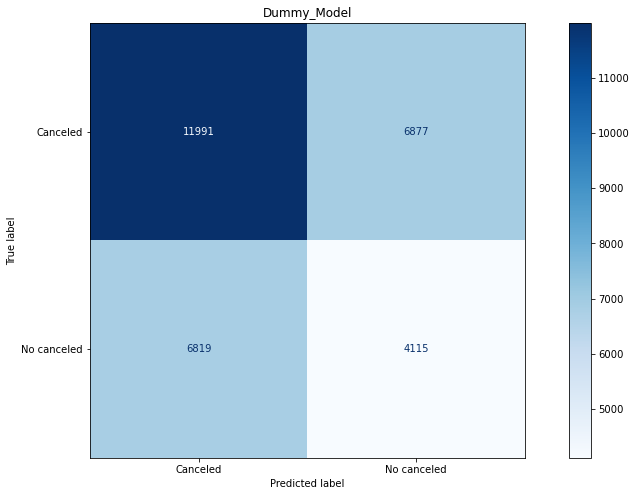

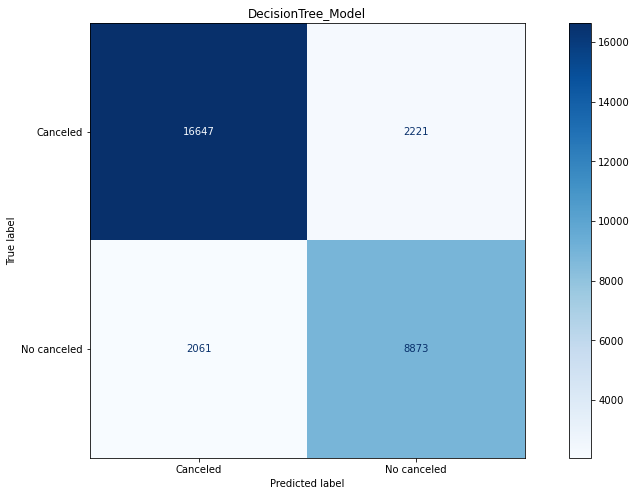

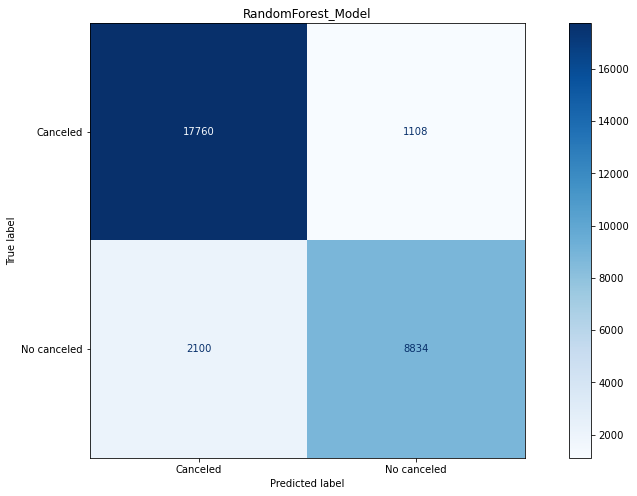

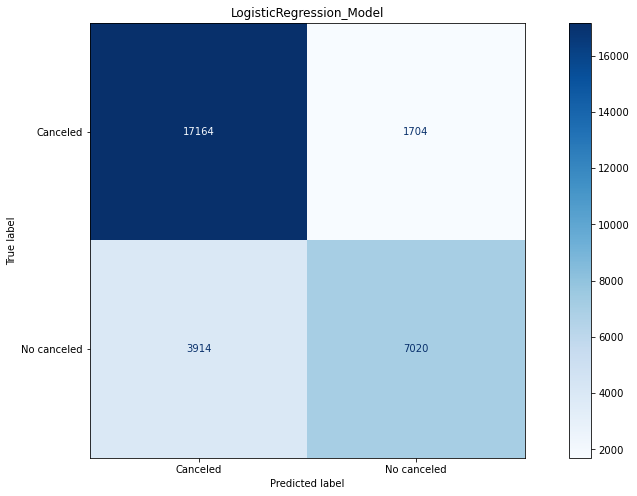

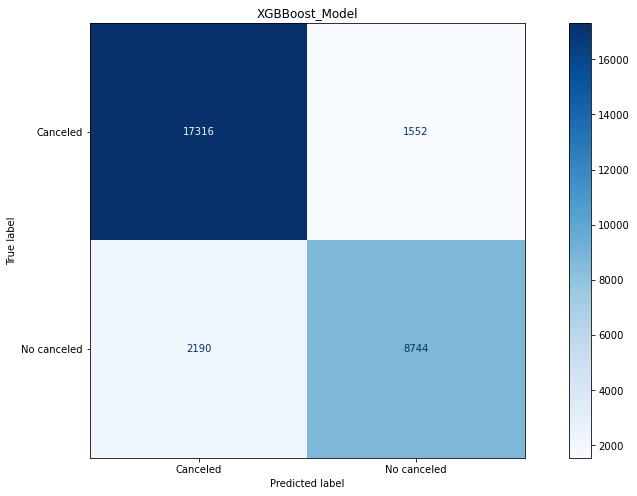

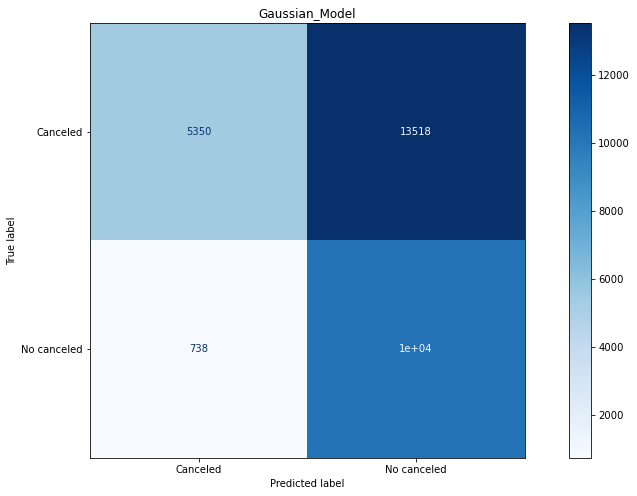

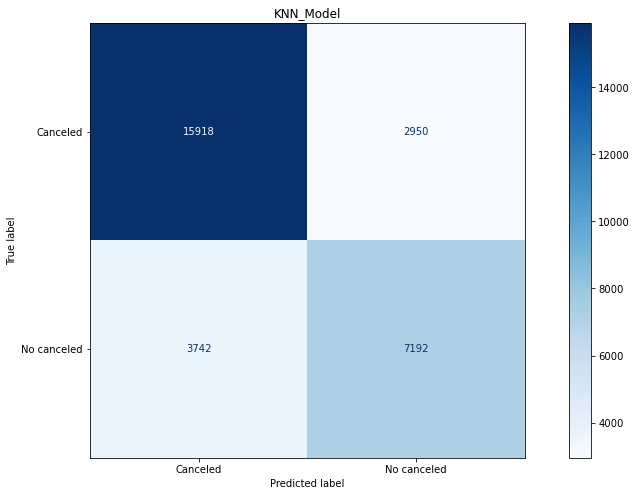

In [23]:
for name, model in models:
    plot_confusion_matrix(model, x1_test, y1_test,display_labels=['Canceled','No canceled'],cmap=plt.cm.Blues)
    plt.title(f"{name}")
    plt.show()

In [24]:
# ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(x, y)
# importance = np.abs(ridge.coef_)
# feature_names = np.array(x.columns)
# feature_names.shape

# plt.bar(height=importance, x=feature_names)
# plt.title("Feature importances via coefficients")
# plt.show()

# from sklearn.feature_selection import SelectFromModel
# from time import time

# threshold = np.sort(importance)[-120] + 0.01

# tic = time()
# sfm = SelectFromModel(ridge, threshold=threshold).fit(x, y)
# toc = time()
# print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
# print(f"Done in {toc - tic:.3f}s")

In [25]:
# x_n = data_df[feature_names[sfm.get_support()]]
# y_n = np.array(data_df["is_canceled"])

# x_train_n, x_rest_n, y_train_n, y_rest_n = train_test_split(x_n, y_n, test_size=0.40, random_state = 2022)
# x_val_n, x_test_n, y_val_n, y_test_n = train_test_split(x_n, y_n, test_size=0.50, random_state = 2022)

# model2 = LogisticRegression(solver="liblinear")
# model2.fit(x_train_n, y_train_n)

# y_pred_n = model2.predict(x_test_n)

# print("Raport klasyfikacyjny:\n", classification_report(y_test_n, y_pred_n))
# print("Accuracy:", metrics.accuracy_score(y_test_n, y_pred_n))
# print("Precision:", metrics.precision_score(y_test_n, y_pred_n))
# print("Recall:", metrics.recall_score(y_test_n, y_pred_n))
# print("Fbeta:", metrics.fbeta_score(y_test_n, y_pred_n, beta=0.5))

# plot_roc_curve(model2, x_train_n, y_train_n)
# pass

In [26]:
# from sklearn.feature_selection import SequentialFeatureSelector

# tic_fwd = time()
# sfs_forward = SequentialFeatureSelector(
#     ridge, n_features_to_select=2, direction="forward"
# ).fit(x, y)
# toc_fwd = time()

# tic_bwd = time()
# sfs_backward = SequentialFeatureSelector(
#     ridge, n_features_to_select=2, direction="backward"
# ).fit(x, y)
# toc_bwd = time()

# print(
#     "Features selected by forward sequential selection: "
#     f"{feature_names[sfs_forward.get_support()]}"
# )
# print(f"Done in {toc_fwd - tic_fwd:.3f}s")
# print(
#     "Features selected by backward sequential selection: "
#     f"{feature_names[sfs_backward.get_support()]}"
# )
# print(f"Done in {toc_bwd - tic_bwd:.3f}s")

In [27]:
# scaler = StandardScaler()
# X_std = scaler.fit_transform(x)

# x_train_std, x_rest_std, y_train_std, y_rest_std = train_test_split(X_std, y, test_size=0.40, random_state = 2022)
# x_val_std, x_test_std, y_val_std, y_test_std = train_test_split(X_std, y, test_size=0.50, random_state = 2022)

# # Perform GridSearchCV to tune best-fit LR model
# parameters = {"C": [10**-2,10**-1,10**0,10**1,10**2], "penalty": ["l1","l2"]}

# # lr_model = LogisticRegression(penalty="l1", solver="liblinear")
# gs_model = GridSearchCV(estimator=model, param_grid=parameters)
# gs_model.fit(x_train_std, y_train)
# gs_model

# # Train a LR model with best parameters
# model = LogisticRegression(**gs_model.best_params_, solver="liblinear")
# model.fit(x_train_std, y_train)